In [1]:
import sys
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
import scipy.ndimage.interpolation as ndii
import pprint
import time

In [2]:


# global constants
RE_IDX = 0
IM_IDX = 1
ROWS_AXIS = 0
COLS_AXIS = 1
polarMode = "spline"
noiseMode = "none" # "gaussian", "s&p", "none"
noiseIntensity = {'sigma' : 2, 'mean' : 0, 'whiteThreshold' : 0.01, 'blackThreshold' : 0.99}
resultsComparation = False

def computeLogPolarParameters(img):
    centerTrans = [math.floor((img.shape[ROWS_AXIS] + 1) / 2), math.floor((img.shape[COLS_AXIS] + 1 ) / 2)]

    maxDiff = np.maximum(centerTrans, np.asarray(img.shape) - centerTrans)
    maxDistance = ((maxDiff[0] ** 2 + maxDiff[1] ** 2 ) ** 0.5)
    dimsLogPolar = [0,0]
    dimsLogPolar[COLS_AXIS] = img.shape[COLS_AXIS]
    dimsLogPolar[ROWS_AXIS] = img.shape[ROWS_AXIS]
    # Step 2.1 - Estimate log base
    logBase = math.exp(math.log(maxDistance) / dimsLogPolar[COLS_AXIS])
    # Step 3 - Calculate step for angle in log polar coordinates
    angleStep = ( 1.0 * math.pi ) / dimsLogPolar[ROWS_AXIS]
    return (centerTrans, angleStep, logBase)


def convertToLogPolar(img, centerTrans, angleStep, logBase, mode = "nearest"):
    if mode == "nearest":
        # Step 1 - Initialize transformed image
        transformedImage = np.zeros(img.shape, dtype = img.dtype)
        # Step 2 - Apply reverse log polar transformation
        for radius in range(img.shape[COLS_AXIS]): # start with radius, because calculating exponential power is time consuming
            actRadius = logBase ** radius
            for angle in range(img.shape[ROWS_AXIS]):
                anglePi =  angle * angleStep
                row = int(centerTrans[ROWS_AXIS] + actRadius * math.sin(anglePi))
                col = int(centerTrans[COLS_AXIS] + actRadius * math.cos(anglePi))
                if 0 <= row < img.shape[ROWS_AXIS] and 0 <= col < img.shape[COLS_AXIS]:
                    transformedImage[angle, radius] = img[row, col]

        return transformedImage
    else:
        print("Base: " + str(logBase))
        anglesMap = np.zeros(img.shape, dtype=np.float64)
        anglesVector = -np.linspace(0, np.pi, img.shape[0], endpoint=False)
        anglesMap.T[:] = anglesVector
        radiusMap = np.zeros(img.shape, dtype=np.float64)
        radiusVector = np.power(logBase, np.arange(img.shape[1], dtype=np.float64)) - 1.0
        radiusMap[:] = radiusVector
        x = radiusMap * np.sin(anglesMap) + centerTrans[1]
        y = radiusMap * np.cos(anglesMap) + centerTrans[0]
        outputImg = np.zeros(img.shape)
        ndii.map_coordinates(img, [x, y], output=outputImg)
        return outputImg


def phaseCorrelation(img_orig, img_transformed):
    orig_conj = np.copy(img_orig)
    orig_conj[:,:,IM_IDX] = -orig_conj[:,:,IM_IDX]
    orig_mags = cv2.magnitude(img_orig[:,:,RE_IDX],img_orig[:,:,IM_IDX])
    img_trans_mags = cv2.magnitude(img_transformed[:,:,RE_IDX],img_transformed[:,:,IM_IDX])
    realPart = (orig_conj[:,:,RE_IDX] * img_transformed[:,:,RE_IDX] - orig_conj[:,:,IM_IDX] * img_transformed[:,:,IM_IDX]) / (orig_mags * img_trans_mags)
    imaginaryPart = (orig_conj[:,:,RE_IDX] * img_transformed[:,:,IM_IDX] + orig_conj[:,:,IM_IDX] * img_transformed[:,:,RE_IDX]) / ( orig_mags * img_trans_mags)
    result = np.dstack((realPart, imaginaryPart))
    result_idft = cv2.idft(result)
    result_mags = cv2.magnitude(result_idft[:,:,RE_IDX],result_idft[:,:,IM_IDX])
    return np.unravel_index( np.argmax(result_mags), result_mags.shape)


def addNoiseToImage(img, noise, noiseIntensity):
    if noise == 's&p':
        print("Adding S&P Noise: wT = " + str(noiseIntensity['whiteThreshold']) + "; bT = " + str(noiseIntensity['blackThreshold']))
        distData = np.random.uniform(0.0, 1.0, img.shape).reshape(img.shape)
        img[distData < noiseIntensity['whiteThreshold']] = 255
        img[distData > noiseIntensity['blackThreshold']] = 0
        return img
    else:
        if noise == 'gaussian':
            print("Adding Gaussian noise: sigma = " + str(noiseIntensity['sigma']) + '; mean = ' + str(noiseIntensity['mean']))
            return noiseIntensity['sigma'] * np.random.randn(img.shape[0], img.shape[1]) + img + noiseIntensity['mean']
        else:
            return img

def readImage(img):
    imgData = cv2.imread(img,0)
    imgData = addNoiseToImage(imgData, noiseMode, noiseIntensity)
    imgFft, imgFftShifted = calculateFft(imgData)
    imgMags = cv2.magnitude(imgFftShifted[:,:,RE_IDX],imgFftShifted[:,:,IM_IDX])
    return (imgData, imgFftShifted, imgMags)

def prepareHighPassFilter(img):
    pi2 = math.pi / 2.0
    rows = np.cos(np.linspace(-pi2, pi2, img.shape[0]))
    cols = np.cos(np.linspace(-pi2, pi2, img.shape[1]))
    x = np.outer( rows, cols)
    return (1.0 - x) * (2.0 - x)


def calculateFft(img):
    imgTmp  = np.float32(img)
    imgFft = cv2.dft(imgTmp,flags = cv2.DFT_COMPLEX_OUTPUT)
    imgFftShifted = np.fft.fftshift(imgFft)
    return (imgFft, imgFftShifted)



Base: 1.0063475963607669
Base: 1.0063475963607669


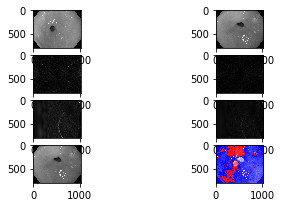

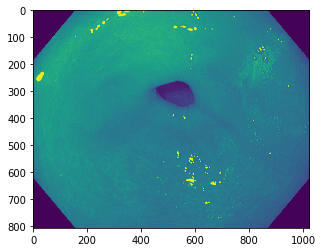

In [9]:
 
imgOriginal, imgOriginalFft, imgOriginalMags = readImage('A1.tif')
imgTransformed, imgTransformedFft, imgTransformedMags = readImage('B1.tif')

highPassFilter = prepareHighPassFilter(imgOriginalMags)
imgOriginalMagsFilter = imgOriginalMags * highPassFilter
imgTransformedMagsFilter = imgTransformedMags * highPassFilter
centerTrans, angleStep, logBase = computeLogPolarParameters(imgOriginalMagsFilter)
imgOriginalLogPolar = convertToLogPolar(imgOriginalMagsFilter, centerTrans, angleStep, logBase, polarMode)
imgTransformedLogPolar = convertToLogPolar(imgTransformedMagsFilter, centerTrans, angleStep, logBase, polarMode)

imgOriginalLogPolarComplex = cv2.dft(np.float32(imgOriginalLogPolar),flags = cv2.DFT_COMPLEX_OUTPUT)
imgTransformedLogPolarComplex = cv2.dft(np.float32(imgTransformedLogPolar),flags = cv2.DFT_COMPLEX_OUTPUT)

angle, scale = phaseCorrelation(imgOriginalLogPolarComplex, imgTransformedLogPolarComplex)
angleDeg = -(float(angle) * 180.0 ) / imgOriginalLogPolarComplex.shape[0]
if angleDeg < - 45:
            angleDeg += 180
else:
            if angleDeg > 90.0:
                angleDeg -= 180

scaleFactor = logBase ** scale

transformMatrix = cv2.getRotationMatrix2D((centerTrans[0], centerTrans[1]), angleDeg, scaleFactor)
imgTransformedNew = cv2.warpAffine(imgTransformed, transformMatrix, (imgTransformed.shape[1], imgTransformed.shape[0]) )
imgTransformedNewFft, imgTransformedNewftShifted = calculateFft(imgTransformedNew)
y, x = phaseCorrelation(imgTransformedNewftShifted, imgOriginalFft)
if x > imgOriginal.shape[0] // 2:
    x -= imgOriginal.shape[0]
if y > imgOriginal.shape[1] // 2:
    y -= imgOriginal.shape[1]

translationMatrix = np.float32([[1,0,-x],[0,1,-y]])
imgFinal = cv2.warpAffine(imgTransformedNew, translationMatrix, (imgTransformed.shape[1], imgTransformed.shape[0]))
timeEnd = time.time()
if resultsComparation:
        plt.subplot(221),plt.imshow(imgOriginal, cmap = 'gray')
        plt.subplot(222),plt.imshow(imgTransformed, cmap = 'gray')
        plt.subplot(223),plt.imshow(imgOriginal - imgFinal, cmap = 'bwr')
        plt.subplot(224),plt.imshow(imgFinal, cmap = 'gray')
        plt.show()
else:
        plt.subplot(521),plt.imshow(imgOriginal, cmap = 'gray')
        plt.subplot(522),plt.imshow(imgTransformed, cmap = 'gray')
        plt.subplot(523),plt.imshow(imgOriginalMagsFilter, cmap = 'gray')
        plt.subplot(524),plt.imshow(imgTransformedMagsFilter, cmap = 'gray')
        plt.subplot(525),plt.imshow(imgOriginalLogPolar, cmap = 'gray')
        plt.subplot(526),plt.imshow(imgTransformedLogPolar, cmap = 'gray')
        plt.subplot(527),plt.imshow(imgTransformedNew, cmap = 'gray')
        plt.subplot(528),plt.imshow(imgOriginal - imgFinal, cmap = 'bwr')
        plt.show()
      
    
plt.imshow(imgFinal)
plt.show()
